In [ ]:
import torch
import torch.nn as nn

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

First of all, lets understand what is the number of params in conv layers and what does it depend on and how tensors transforms.

1. **Model parameters** $\longrightarrow$ How many params will model have if we'll use this conv layer, and what if we'll use 3 conv layers of one type, 10 of second type and 20 of third one? We can theoretically compute and analyze this things without any additional tools
2. **$\Delta H, \Delta W, \Delta C$** $\longrightarrow$ What will happen to the image after going through this conv layer? Especially important when you want to stack **a lot** of them one after another or create atypical architecture
3. **Receptive field** $\longrightarrow$ How to interpret model results and find what went wrong, or how exactly model solved the case? How big of a patterns model can phisically capture?

Formula of H,W out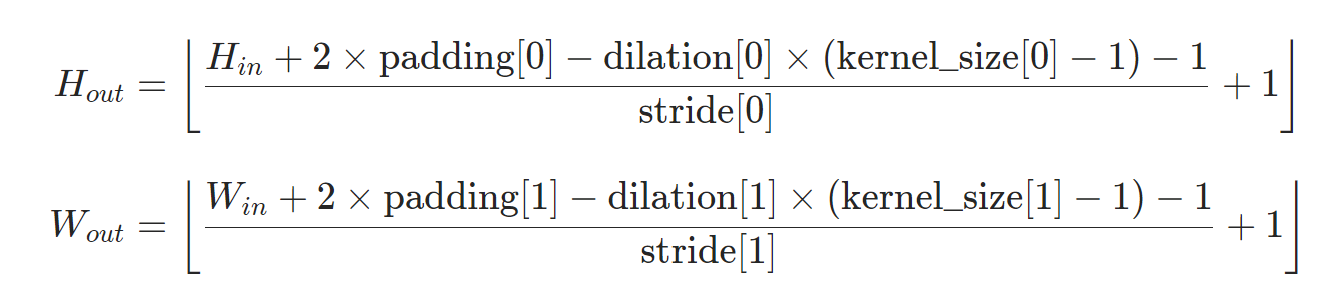

$$((K_h * K_w * C_{in}) + B) * C_{out}$$

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, bias=True)
cnt = 0
for param in conv.parameters():
    print(param.shape)
    cnt += torch.prod(torch.tensor(param.shape))
print(f'{cnt} params')

torch.Size([5, 1, 3, 3])
torch.Size([5])
50 params


In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, bias=False, padding=0)
cnt = 0
for param in conv.parameters():
    print(param.shape)
    cnt += torch.prod(torch.tensor(param.shape))
print(f'{cnt} params')

torch.Size([5, 1, 3, 3])
45 params


In PyTorch when it comes to images tensors have sizes like: [B, C, H, W]

In [ ]:
# conv(torch.randn((1, 28, 28, 1))).shape

In [ ]:
conv(torch.randn((2, 1, 28, 28))).shape

torch.Size([2, 5, 26, 26])

Lets keep the dimensions the same

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=5, padding=1, kernel_size=3)
conv(torch.randn((1, 1, 28, 28))).shape

torch.Size([1, 5, 28, 28])

Try stride

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=5, padding=1, kernel_size=3, stride=2)
conv(torch.randn((1, 1, 28, 28))).shape

torch.Size([1, 5, 14, 14])

Dilation

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=5, padding=0, kernel_size=3, dilation=2)
conv(torch.randn((1, 1, 5, 5))).shape

torch.Size([1, 5, 1, 1])

Conv1d

In [ ]:
conv1d = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=3)
conv1d(torch.randn((4, 5, 10))).shape

torch.Size([4, 10, 8])

In [ ]:
conv1d = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
conv1d(torch.randn((4, 5, 10))).shape

torch.Size([4, 10, 10])

Receptive field
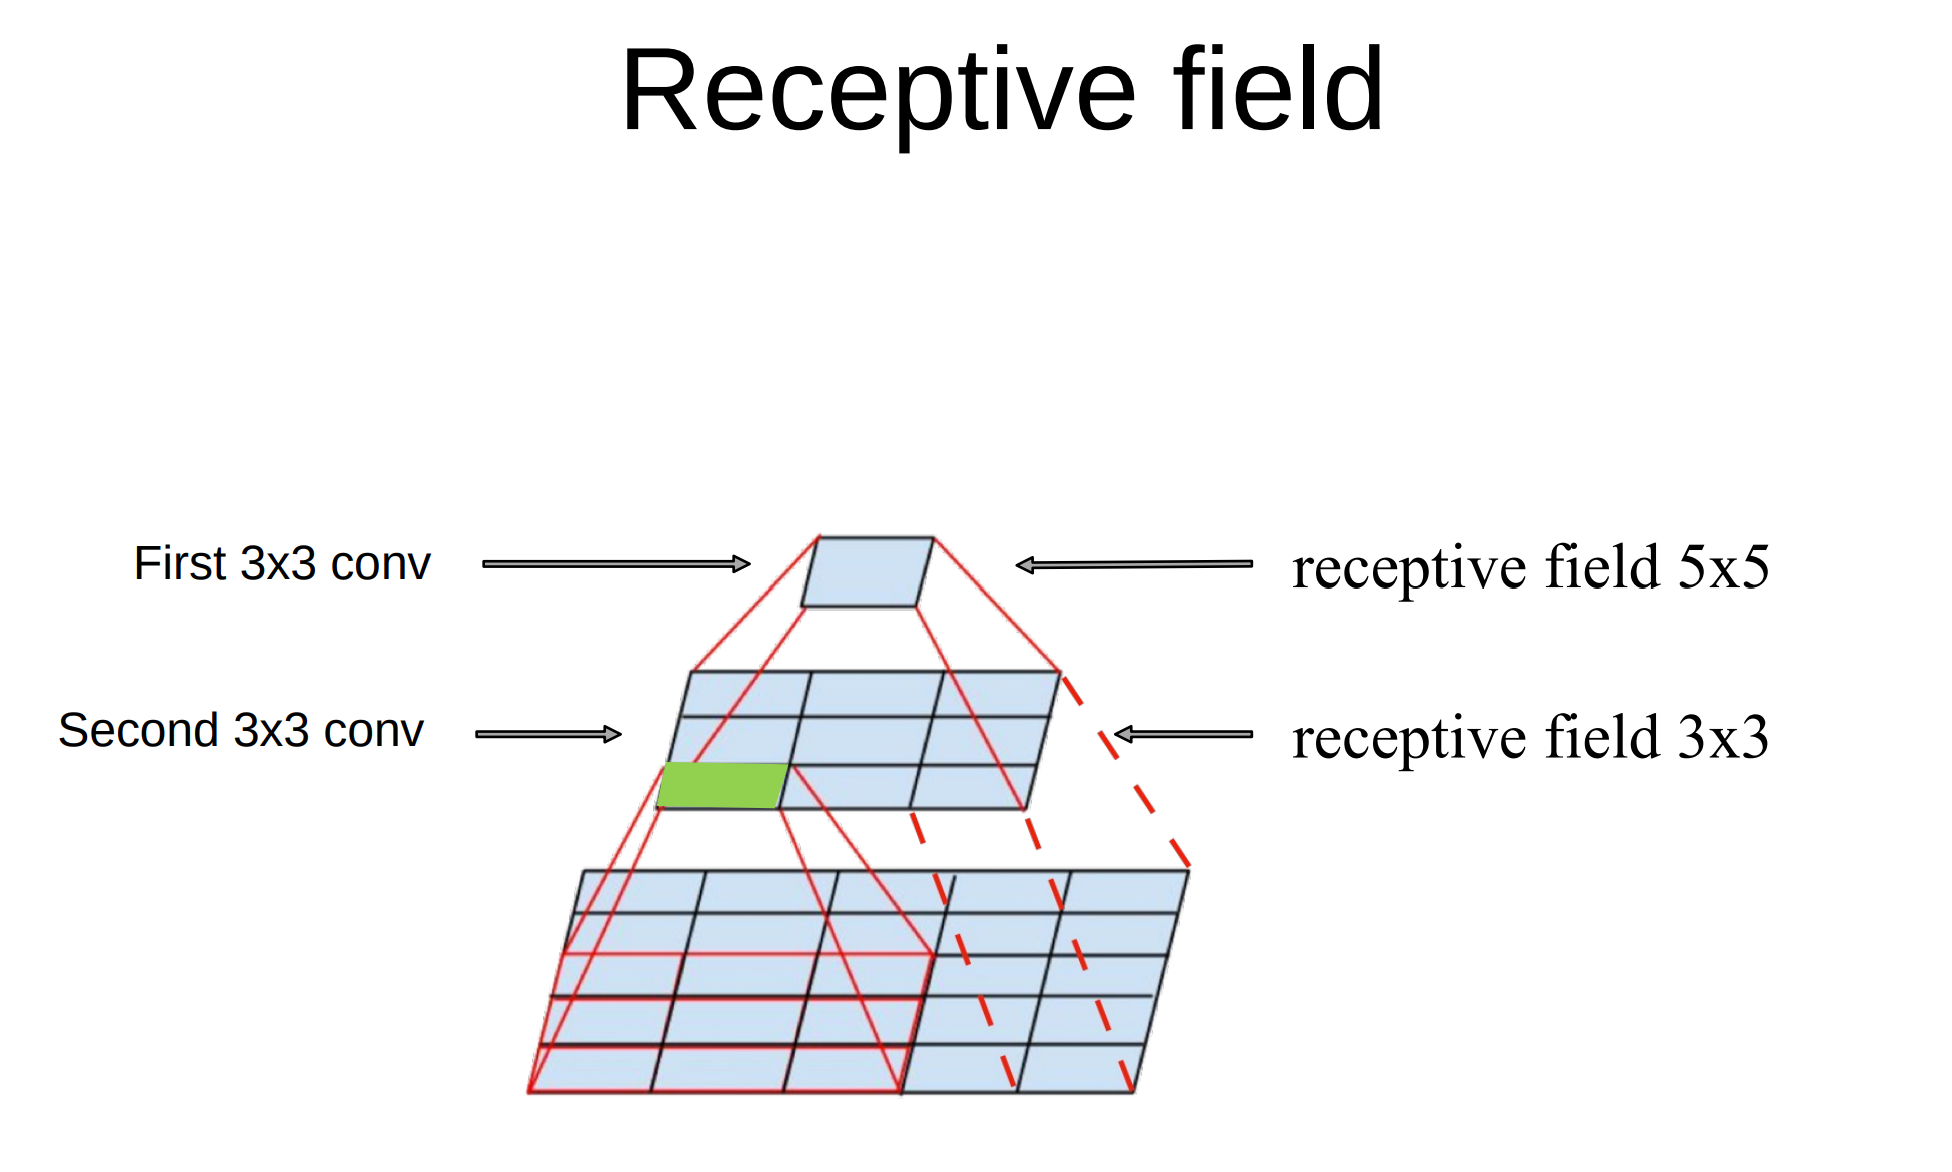

In [ ]:
double_conv = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
)
double_conv(torch.randn((1, 1, 5, 5))).shape

torch.Size([1, 1, 1, 1])

# Let's play with models

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2024-09-25 17:16:56--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2024-09-25 17:16:56 (33.4 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


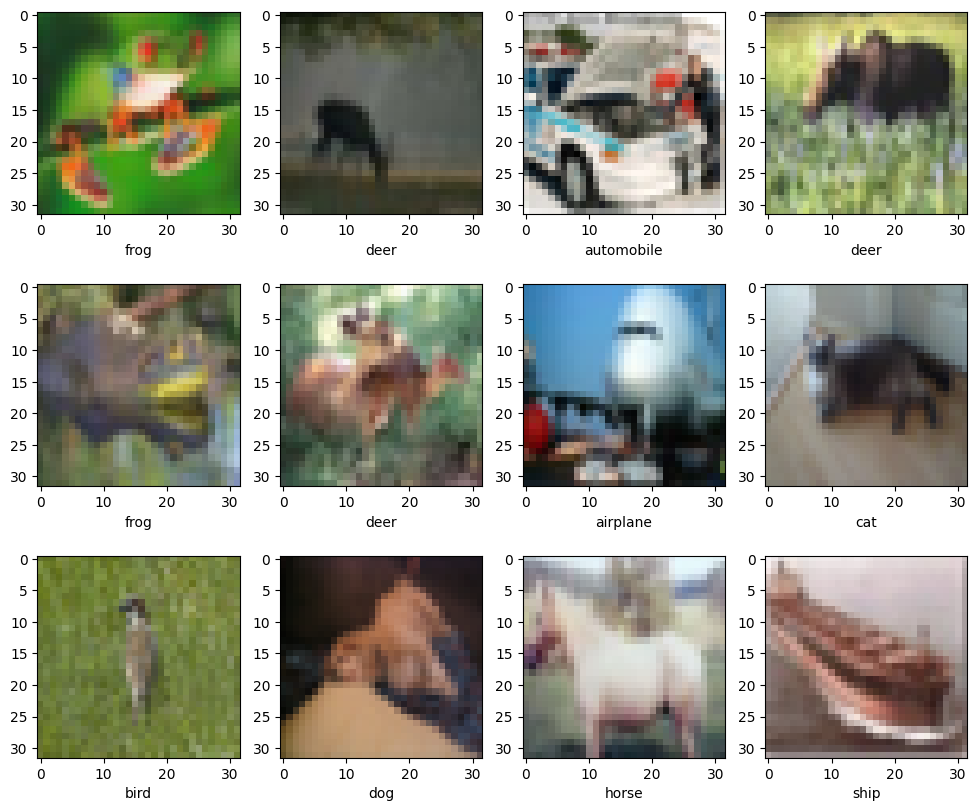

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
nn.Flatten()

Flatten(start_dim=1, end_dim=-1)

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
3 * 32*32

3072

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2655, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

In [ ]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.eval() # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        loss = compute_loss(X_batch, y_batch)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
        val_loss.append(loss.data.numpy())

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))


Epoch 1 of 20 took 1.616s
  training loss (in-iteration): 	2.018731
  validation accuracy: 			34.18 %
Epoch 2 of 20 took 1.766s
  training loss (in-iteration): 	1.852168
  validation accuracy: 			35.61 %
Epoch 3 of 20 took 2.350s
  training loss (in-iteration): 	1.787751
  validation accuracy: 			38.95 %
Epoch 4 of 20 took 1.603s
  training loss (in-iteration): 	1.740000
  validation accuracy: 			40.21 %
Epoch 5 of 20 took 1.539s
  training loss (in-iteration): 	1.701676
  validation accuracy: 			40.55 %
Epoch 6 of 20 took 1.556s
  training loss (in-iteration): 	1.667446
  validation accuracy: 			41.53 %
Epoch 7 of 20 took 1.546s
  training loss (in-iteration): 	1.638705
  validation accuracy: 			43.09 %
Epoch 8 of 20 took 1.556s
  training loss (in-iteration): 	1.614809
  validation accuracy: 			43.22 %
Epoch 9 of 20 took 1.526s
  training loss (in-iteration): 	1.593691
  validation accuracy: 			43.43 %
Epoch 10 of 20 took 1.809s
  training loss (in-iteration): 	1.574801
  validation 

In [ ]:
model.eval() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
  test accuracy:		47.83 %


In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))

model.add_module('conv2', nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('flatten', Flatten())
model.add_module('fc', nn.Linear(640, 10))

In [ ]:
model(torch.randn(2, 3, 32, 32)).shape

torch.Size([2, 10])

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 16, 3))
model.add_module('bnl', nn.BatchNorm2d(16))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pool', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(16, 32, 3))
model.add_module('bn2', nn.BatchNorm2d(32))
model.add_module('conv2_relu', nn.ReLU())
# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())
#dense "head"
model.add_module('densel', nn.Linear(5408, 64))
# model.add_module('bn3', nn.BatchNorm1d(64))
model.add_module('dense_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits

In [ ]:
model(torch.randn(2, 3, 32, 32)).shape

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        loss = compute_loss(X_batch, y_batch)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
        val_loss.append(loss.data.numpy())

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))


Epoch 1 of 20 took 17.442s
  training loss (in-iteration): 	2.134829
  validation accuracy: 			31.66 %
Epoch 2 of 20 took 18.747s
  training loss (in-iteration): 	1.911326
  validation accuracy: 			35.77 %
Epoch 3 of 20 took 18.730s
  training loss (in-iteration): 	1.792014
  validation accuracy: 			40.65 %
Epoch 4 of 20 took 18.841s
  training loss (in-iteration): 	1.656428
  validation accuracy: 			39.22 %
Epoch 5 of 20 took 17.988s
  training loss (in-iteration): 	1.569143
  validation accuracy: 			43.82 %
Epoch 6 of 20 took 17.549s
  training loss (in-iteration): 	1.511647
  validation accuracy: 			48.57 %
Epoch 7 of 20 took 18.332s
  training loss (in-iteration): 	1.466239
  validation accuracy: 			50.00 %
Epoch 8 of 20 took 17.560s
  training loss (in-iteration): 	1.432453
  validation accuracy: 			51.04 %
Epoch 9 of 20 took 17.420s
  training loss (in-iteration): 	1.405624
  validation accuracy: 			49.11 %
Epoch 10 of 20 took 17.660s
  training loss (in-iteration): 	1.376082
  v

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

One more

In [ ]:
model = nn.Sequential()
model.add_module('conv l', nn.Conv2d(3, 16, 3))
model.add_module('bnl', nn.BatchNorm2d(16))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pool', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(16, 32, 3))
model.add_module('bn2', nn.BatchNorm2d(32))
model.add_module('conv2_relu', nn.ReLU())
model.add_module('conv3', nn.Conv2d(32, 32, 3))
model.add_module('bn3', nn.BatchNorm2d(32))
model.add_module('conv3_relu', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('conv4', nn.Conv2d(32, 64, 3))
model.add_module('bn4', nn.BatchNorm2d(64))
model.add_module('conv4_relu', nn.ReLU())
#reshape from "images" to flat vectors
model.add_module('flätten', Flatten())
# dense "head"
model.add_module('densel', nn.Linear(576, 64))
model.add_module('bn5', nn.BatchNorm1d(64))
model.add_module('densely_relu', nn.ReLU())
model.add_module('dense 2_logits', nn.Linear(64, 10)) # logits for 10 classes

In [ ]:
model(torch.randn(2, 3, 32, 32)).shape

there is a tendency to use convolutional layers with stride instead of pulling

In [ ]:
#TODO to cuda

# ResNet Block

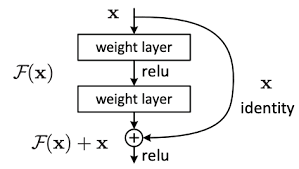

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2= nn.Conv2d(out_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        y = self.conv2(self.relu(self.conv1(x)))
        y = self.relu(y + x)
        return y

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += identity
    out = self.relu(out)
    return out

In [ ]:
resblock = ResBlock(3, 5)
resblock(torch.randn(2, 3, 12, 12)).shape

torch.Size([2, 3, 12, 12])

# Custom Datasets and Dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass


# Transforms

In [ ]:
from torchvision.transforms import v2

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/astronaut.jpg

--2024-09-25 17:57:48--  https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/astronaut.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40344 (39K) [image/jpeg]
Saving to: ‘astronaut.jpg’

astronaut.jpg       100%[===================>]  39.40K  --.-KB/s    in 0.01s   

2024-09-25 17:57:48 (3.50 MB/s) - ‘astronaut.jpg’ saved [40344/40344]



In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/transforms/helpers.py

--2024-09-25 17:58:03--  https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/transforms/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2022 (2.0K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]   1.97K  --.-KB/s    in 0s      

2024-09-25 17:58:03 (33.7 MB/s) - ‘helpers.py’ saved [2022/2022]



In [ ]:
from helpers import plot

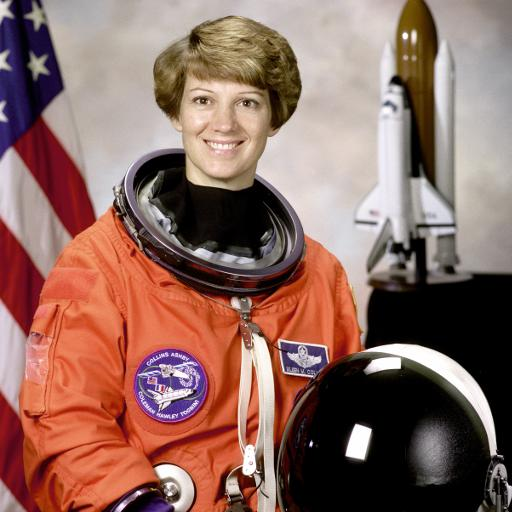

In [ ]:
from PIL import Image
orig_img = Image.open('astronaut.jpg')
orig_img

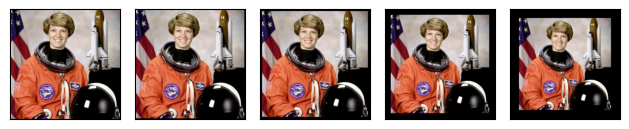

In [ ]:
padded_imgs = [v2.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot([orig_img] + padded_imgs)

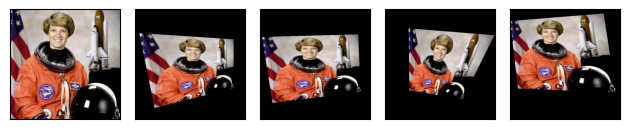

In [ ]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot([orig_img] + perspective_imgs)

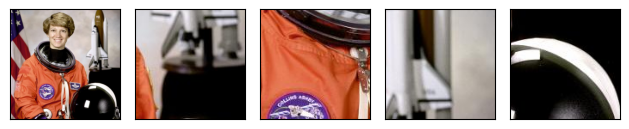

In [ ]:
cropper = v2.RandomCrop(size=(128, 128))
crops = [cropper(orig_img) for _ in range(4)]
plot([orig_img] + crops)

# Architetures

In [ ]:
from torchvision import models

In [ ]:
models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
models.resnet152()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
models.mobilenet_v3_small()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Handmade conv TODO

In [ ]:
batch_size = 2
channels = 5
h, w = 12, 12
image = torch.randn(batch_size, channels, h, w) # input image

kh, kw = 3, 3 # kernel size
dh, dw = 3, 3 # stride

# Create conv
conv = nn.Conv2d(5, 7, (kh, kw), stride=(dh, dw), bias=False)
filt = conv.weight

# Manual approach
patches = image.unfold(2, kh, dh).unfold(3, kw, dw)
print(patches.shape) # batch_size, channels, h_windows, w_windows, kh, kw

patches = patches.contiguous().view(batch_size, channels, -1, kh, kw)
print(patches.shape) # batch_size, channels, windows, kh, kw

nb_windows = patches.size(2)

# Now we have to shift the windows into the batch dimension.
# Maybe there is another way without .permute, but this should work
patches = patches.permute(0, 2, 1, 3, 4)
print(patches.shape) # batch_size, nb_windows, channels, kh, kw

# Calculate the conv operation manually
res = (patches.unsqueeze(2) * filt.unsqueeze(0).unsqueeze(1)).sum([3, 4, 5])
print(res.shape) # batch_size, output_pixels, out_channels
res = res.permute(0, 2, 1) # batch_size, out_channels, output_pixels
# assuming h = w
h = w = int(res.size(2)**0.5)
res = res.view(batch_size, -1, h, w)

# Module approach
out = conv(image)


print('max abs error ', (out - res).abs().max())